In [1]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import plotnine as gg
from analysis import utils as au
from analysis import plotting
from data import utils as du
from data import se3_diffuser
from data import r3_diffuser
from data import so3_diffuser
import seaborn as sns
from model import loss
from model import score_network
from model import ipa_pytorch
import tree
from data import rosetta_data_loader
from data import digs_data_loader
from data import all_atom
from openfold.data import data_transforms
from experiments import train_se3_diffusion
from experiments import inference_se3_diffusion
from openfold.utils import rigid_utils as ru
from openfold.np import residue_constants
from openfold.utils import loss as of_loss
from scipy.spatial.transform import Rotation
import geomstats.visualization as visualization
import esm
import pandas as pd
pd.set_option('display.max_colwidth', None)

from omegaconf import DictConfig, OmegaConf
import importlib

# Enable logging
import logging
import sys
date_strftime_format = "%Y-%m-%y %H:%M:%S"
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(asctime)s %(message)s", datefmt=date_strftime_format)

INFO: Using numpy backend


In [2]:
importlib.reload(rosetta_data_loader)
importlib.reload(digs_data_loader)
importlib.reload(se3_diffuser)
importlib.reload(so3_diffuser)
importlib.reload(r3_diffuser)
importlib.reload(du)
importlib.reload(au)
importlib.reload(all_atom)
importlib.reload(plotting)
importlib.reload(loss)
importlib.reload(score_network)
importlib.reload(ipa_pytorch)
importlib.reload(inference_se3_diffusion)
importlib.reload(train_se3_diffusion)

<module 'experiments.train_se3_diffusion' from '/data/rsg/chemistry/jyim/projects/protein_diffusion/experiments/train_se3_diffusion.py'>

In [13]:
from Bio import PDB
from data import parsers
import collections
import dataclasses
import functools
import io


In [6]:
import plotly.graph_objects as go

In [7]:
def parse_chain_feats(chain_feats, scale_factor=1.):
    ca_idx = residue_constants.atom_order['CA']
    chain_feats['bb_mask'] = chain_feats['atom_mask'][:, ca_idx]
    bb_pos = chain_feats['atom_positions'][:, ca_idx]
    centered_pos = chain_feats['atom_positions']
    scaled_pos = centered_pos / scale_factor
    chain_feats['atom_positions'] = scaled_pos * chain_feats['atom_mask'][..., None]
    chain_feats['bb_positions'] = chain_feats['atom_positions'][:, ca_idx]
    return chain_feats

In [11]:
def get_chain(pdb_path, chain_id):
    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure('test', pdb_path)

    # Extract all chains
    struct_chains = {
        chain.id.upper(): chain
        for chain in structure.get_chains()}
    chain_prot = parsers.process_chain(struct_chains['A'], chain_id)
    chain_dict = dataclasses.asdict(chain_prot)
    chain_dict = parse_chain_feats(chain_dict)
    return chain_dict


In [14]:
all_chains = {}
for i in range(1, 6):
    path = f'3J1Q_A_{str(i)}.pdb'
    all_chains[i] = get_chain(path, str(i))
complex_feats = du.concat_np_features(all_chains.values(), False)

In [31]:
bb_pos = complex_feats['bb_positions']
bb_mask = complex_feats['bb_mask']
center = np.sum(bb_pos, axis=0) / (np.sum(bb_mask) + 1e-5)


In [32]:
all_traces = []
for i in range(1, 6):
    sample_bb_3d = plotting.create_scatter(
        all_chains[i]['bb_positions'] - center[None, :],
        marker_size=2,
        mode='lines+markers'
    )
    all_traces.append(sample_bb_3d)

In [41]:
ax_range = (-200, 200)
fig = go.Figure(
    data=all_traces,
    layout={
        'height': 1000,
        'width': 1000,
        'scene' : {
            'xaxis_visible': False,
            'yaxis_visible': False,
            'zaxis_visible': False,
            # 'xaxis': {
            #     'showgrid': False,
            #     'zeroline': False,
            #     'showline': False,
            #     'ticks': '',
            #     'showticklabels': False,
            #     # 'range': ax_range
            # },
            # 'yaxis': {
            #     'showgrid': False,
            #     'zeroline': False,
            #     'showline': False,
            #     'ticks': '',
            #     'showticklabels': False,
            #     # 'range': ax_range
            # },
            # 'zaxis': {
            #     'showgrid': False,
            #     'zeroline': False,
            #     'showline': False,
            #     'ticks': '',
            #     'showticklabels': False,
            #     # 'range': ax_range
            # },
        }
        # yaxis: {
        #     autorange: true,
        #     showgrid: false,
        #     zeroline: false,
        #     showline: false,
        #     autotick: true,
        #     ticks: '',
        #     showticklabels: false
        # },
        # zaxis: {
        #     autorange: true,
        #     showgrid: false,
        #     zeroline: false,
        #     showline: false,
        #     autotick: true,
        #     ticks: '',
        #     showticklabels: false
        # },
        # }
    }
)
fig.show()

In [42]:
# Load config.
conf = OmegaConf.load('../../config/base.yaml')

# Redirect cache from notebook directory.
exp_conf = conf.experiment
exp_conf.data_location = 'rosetta'
exp_conf.ckpt_dir = None
exp_conf.num_loader_workers = 1
exp_conf.dist_mode = 'single'
exp_conf.use_wandb = False
exp_conf.batch_size = 1

# Data settings
data_conf = conf.data

# Diffusion settings
diff_conf = conf.diffuser
# diff_conf.se3.r3.coordinate_scaling = 0.25
diff_conf.se3.r3.schedule = 'linear'

# Print out the config
# print(OmegaConf.to_yaml(conf))

# Create experiment and data loaders
exp = train_se3_diffusion.Experiment(conf=conf)
train_loader = exp.create_rosetta_dataset(0, 1)

se3_diff = exp.diffuser.se3_diffuser
r3_diff = se3_diff._r3_diffuser
so3_diff = se3_diff._so3_diffuser


INFO: Using cached IGSO3.
INFO: Number of model parameters 17446190
INFO: Checkpoint not being saved.
INFO: Training: 20312 examples
INFO: Validation: 40 examples with lengths [ 60 108 157 206 254 303 352 400 449 511]


In [ ]:
        for i in range(order):
            deg = i * 360.0 / order
            r = Rotation.from_euler('z', deg, degrees=True)
            sym_rots.append(format_rots(r.as_matrix()))
        self.sym_rots = sym_rots
        self.order = order

In [67]:
np.sqrt(1 - np.exp(-r3_diff.marginal_b_t(t)))

0.9999784068923386

In [71]:
t = 1.0
noise_t = np.random.normal(
    loc=0,
    scale=np.sqrt(1 - np.exp(-r3_diff.marginal_b_t(t))),
    size=all_chains[1]['bb_positions'].shape
)
def diffuse(x_0):
    # return noise_t
    # x_0 = x - center[None, :]
    x_0 = x_0 / 10
    x_t = np.exp(-1/2*r3_diff.marginal_b_t(t))*x_0 + noise_t
    x_t = x_t * 10
    return x_t

In [72]:
all_traces = []
for i in range(1, 6):
    sample_bb_3d = plotting.create_scatter(
        diffuse(all_chains[i]['bb_positions']),
        marker_size=2,
        mode='lines+markers'
    )
    all_traces.append(sample_bb_3d)

In [73]:
ax_range = (-200, 200)
fig = go.Figure(
    data=all_traces,
    layout={
        'height': 1000,
        'width': 1000,
        'scene' : {
            'xaxis_visible': False,
            'yaxis_visible': False,
            'zaxis_visible': False,
        }
    }
)
fig.show()

In [ ]:
rigids_1 = se3_diff.forward_marginal(
    rigids_0=ru.Rigid.from_tensor_7(rigids_0),
    aatype_probs_0=aatype_probs,
    t_seq=0.0,
    t_struct=1.0,
    diffuse_mask=None
)['rigids_t']
rigids_1[:, 4:] *= 0.3

In [25]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

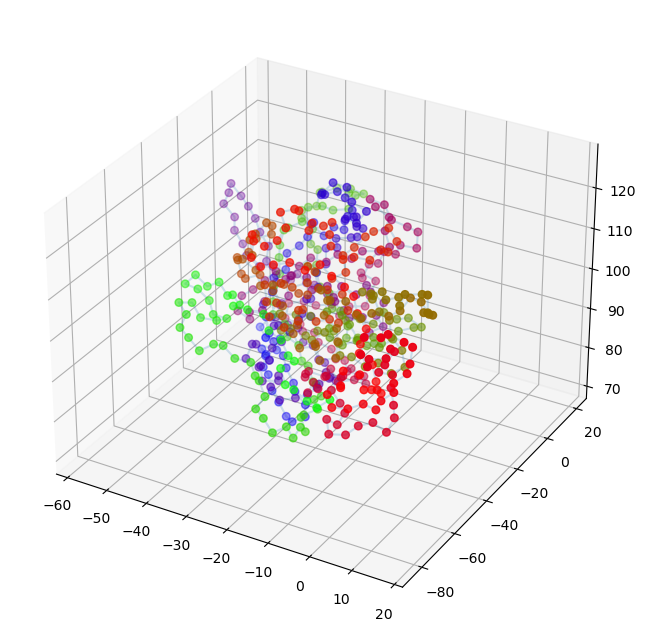

In [27]:
fig, ax = plt.subplots(1, 1, figsize=[8, 8], subplot_kw=dict(projection="3d"))
points = all_chains[i]['bb_positions']
colors = cm.brg(np.linspace(0, 1, points.shape[0]))
_ = plotting.plt_3d(points, ax, color=colors, s=30, mode='scatter')#, ax_lim=ax_lim) 
_ = plotting.plt_3d(points, ax, color=colors, s=30, mode='line')#, ax_lim=ax_lim)

In [35]:
chain_prot = parsers.process_chain(struct_chains['A'], 'A')

In [37]:
chain_prot.atom_positions.shape

(517, 37, 3)

In [5]:
from data import mmcif_parsing

In [16]:
import collections
import dataclasses
import functools
import io
from typing import Any, Mapping, Optional, Sequence, Tuple

from absl import logging
from Bio import PDB
from Bio.Data import SCOPData

In [14]:
mmcif_path = 'symmetric_pentamer.cif'
with open(mmcif_path, 'r') as f:
    parsed_mmcif = mmcif_parsing.parse(
        file_id='test', mmcif_string=f.read(), catch_all_errors=True)
# parsed_mmcif = parsed_mmcif.mmcif_object
# raw_mmcif = parsed_mmcif.raw_string

In [18]:
mmcif_path = 'symmetric_pentamer.cif'
with open(mmcif_path, 'r') as f:
    mmcif_string = f.read()
    parser = PDB.MMCIFParser(QUIET=True)
    handle = io.StringIO(mmcif_string)
    full_structure = parser.get_structure('', handle)
    first_model_structure = mmcif_parsing._get_first_model(full_structure)

In [20]:
parsed_info = parser._mmcif_dict  # pylint:disable=protected-access
# Ensure all values are lists, even if singletons.
for key, value in parsed_info.items():
      if not isinstance(value, list):
            parsed_info[key] = [value]

header = mmcif_parsing._get_header(parsed_info)

In [23]:
valid_chains = mmcif_parsing._get_protein_chains(parsed_info=parsed_info)

In [ ]:
parsed_info

In [ ]:
struct_chains = {
    chain.id.upper(): chain
    for chain in parsed_mmcif.structure.get_chains()}

In [ ]:
ax_lim = 5
fig, ax = plt.subplots(1, 1, figsize=[8, 8], subplot_kw=dict(projection="3d"))
ax.azim = 270  # xz view

se3_diff = exp.diffuser
aatype_probs = np.zeros([rigids_0.shape[0], 21])
rigids_0 = torch.clone(rigids_0)
rigids_1 = se3_diff.forward_marginal(
    rigids_0=ru.Rigid.from_tensor_7(rigids_0),
    aatype_probs_0=aatype_probs,
    t_seq=0.0,
    t_struct=1.0,
    diffuse_mask=None
)['rigids_t']
rigids_1[:, 4:] *= 0.3


se3_vec = au.rigids_to_se3_vec(du.move_to_np(rigids_1), scale_factor=1.0)
_ = plot_se3(se3_vec, ax=ax, ax_lim=ax_lim)
plt.axis('off')
plt.grid(b=None)
plt.savefig('initialized_frames.png', dpi=300)

In [382]:
def plot_se3(se3_vec, ax_lim=None, title=None, ax=None):
    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection="3d")
    visualization.plot(se3_vec, ax=ax, space="SE3_GROUP")
    bb_trans = se3_vec[:, 3:]
    ln = ax.plot(bb_trans[:,0], bb_trans[:,1], bb_trans[:,2], alpha=0.15, c='black')
    if ax_lim is not None:
        ax.set_xlim(-ax_lim, ax_lim)
        ax.set_ylim(-ax_lim, ax_lim)
        ax.set_zlim(-ax_lim, ax_lim)
    if title:
        ax.set_title(title)
    return ln

In [383]:
train_csv = train_loader[0].dataset.csv
top7_path = train_csv[train_csv.pdb_name == '1qys'].processed_path.iloc[0]
# train_csv.sort_values('seq_len')

In [427]:
raw_csv[raw_csv.oligomeric_detail == 'monomeric'].sort_values('radius_gyration')
# raw_csv.radius_gyration

,pdb_name,processed_path,raw_path,oligomeric_count,oligomeric_detail,resolution,structure_method,num_chains,quaternary_category,seq_len,modeled_seq_len,coil_percent,helix_percent,strand_percent,radius_gyration
46276,6mw1,/data/rsg/chemistry/jyim/large_data/processed_pdb_protdiff/mw/6mw1.pkl,/data/rsg/chemistry/jyim/large_data/pdb/30_08_2021/mmCIF/mw/6mw1.cif,1,monomeric,0.77,x-ray diffraction,1,homomer,5,3,1.333333,0.000000,0.000000,0.421495
46315,6mw2,/data/rsg/chemistry/jyim/large_data/processed_pdb_protdiff/mw/6mw2.pkl,/data/rsg/chemistry/jyim/large_data/pdb/30_08_2021/mmCIF/mw/6mw2.cif,1,monomeric,0.77,x-ray diffraction,1,homomer,4,1,4.000000,0.000000,0.000000,0.425536
38303,5zmz,/data/rsg/chemistry/jyim/large_data/processed_pdb_protdiff/zm/5zmz.pkl,/data/rsg/chemistry/jyim/large_data/pdb/30_08_2021/mmCIF/zm/5zmz.cif,1,monomeric,1.40,x-ray diffraction,1,homomer,5,4,1.000000,0.000000,0.000000,0.467932
53363,6po6,/data/rsg/chemistry/jyim/large_data/processed_pdb_protdiff/po/6po6.pkl,/data/rsg/chemistry/jyim/large_data/pdb/30_08_2021/mmCIF/po/6po6.cif,1,monomeric,1.00,electron crystallography,1,homomer,5,3,1.000000,0.000000,0.000000,0.472729
44286,5zck,/data/rsg/chemistry/jyim/large_data/processed_pdb_protdiff/zc/5zck.pkl,/data/rsg/chemistry/jyim/large_data/pdb/30_08_2021/mmCIF/zc/5zck.cif,1,monomeric,1.27,x-ray diffraction,1,homomer,7,4,1.000000,0.000000,0.000000,0.478166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37200,5szm,/data/rsg/chemistry/jyim/large_data/processed_pdb_protdiff/sz/5szm.pkl,/data/rsg/chemistry/jyim/large_data/pdb/30_08_2021/mmCIF/sz/5szm.cif,1,monomeric,3.60,x-ray diffraction,3,heteromer,433,416,0.471154,0.074519,0.454327,5.474540
37203,5szq,/data/rsg/chemistry/jyim/large_data/processed_pdb_protdiff/sz/5szq.pkl,/data/rsg/chemistry/jyim/large_data/pdb/30_08_2021/mmCIF/sz/5szq.cif,1,monomeric,2.56,x-ray diffraction,2,heteromer,440,422,0.485782,0.047393,0.466825,5.495354
29162,2x10,/data/rsg/chemistry/jyim/large_data/processed_pdb_protdiff/x1/2x10.pkl,/data/rsg/chemistry/jyim/large_data/pdb/30_08_2021/mmCIF/x1/2x10.cif,1,monomeric,3.00,x-ray diffraction,1,homomer,487,485,0.548454,0.018557,0.432990,5.569882
3515,6pgw,/data/rsg/chemistry/jyim/large_data/processed_pdb_protdiff/pg/6pgw.pkl,/data/rsg/chemistry/jyim/large_data/pdb/30_08_2021/mmCIF/pg/6pgw.cif,1,monomeric,3.00,x-ray diffraction,1,homomer,455,427,0.512881,0.037471,0.449649,5.592109


In [419]:
raw_csv = train_loader[0].dataset.raw_csv
monomer_csv = raw_csv[raw_csv.oligomeric_detail.isin(['monomeric'])]
print(monomer_csv.shape)

(24103, 15)


In [420]:
len_filtered = monomer_csv[(60 < monomer_csv.seq_len) & (monomer_csv.seq_len < 512)]
print(len_filtered.shape)

(23913, 15)


In [400]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def _rog_quantile_curve(df, quantile, eval_x):
    quantile = 0.96
    y_quant = pd.pivot_table(
        df,
        values='radius_gyration', 
        index='modeled_seq_len',
        aggfunc=lambda x: np.quantile(x, quantile)
    )
    x_quant = y_quant.index.to_numpy()
    y_quant = y_quant.radius_gyration.to_numpy()

    # Fit polynomial regressor
    poly = PolynomialFeatures(degree=4, include_bias=True)
    poly_features = poly.fit_transform(x_quant[:, None])
    poly_reg_model = LinearRegression()
    poly_reg_model.fit(poly_features, y_quant)

    # Calculate cutoff for all sequence lengths
    pred_poly_features = poly.fit_transform(eval_x[:, None])
    # Add a little more.
    pred_y = poly_reg_model.predict(pred_poly_features) + 0.1
    return pred_y

In [407]:
rog_map = _rog_quantile_curve(
    len_filtered, 
    0.9,
    np.arange(512)
)
row_rog_cutoffs = len_filtered.modeled_seq_len.map(
    lambda x: rog_map[x-1])
rog_filtered = len_filtered[len_filtered.radius_gyration < row_rog_cutoffs]

In [410]:
len_filtered.shape

(54353, 15)

In [421]:
ss_filtered = len_filtered[len_filtered.coil_percent < 0.5]
print(ss_filtered.shape)

In [422]:
ss_filtered.shape

(20392, 15)

In [414]:
train_csv.shape

(19777, 16)

# Plotting noised frames

In [321]:
chain_feats = train_loader[0].dataset._process_csv_row(top7_path)
gt_bb_rigid = ru.Rigid.from_tensor_4x4(chain_feats['rigidgroups_0'])[:, 0]
rigids_0 = gt_bb_rigid.to_tensor_7()
rigids_0[:, 4:] *= 0.55

/tmp/ipykernel_3850866/3831764975.py:8: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


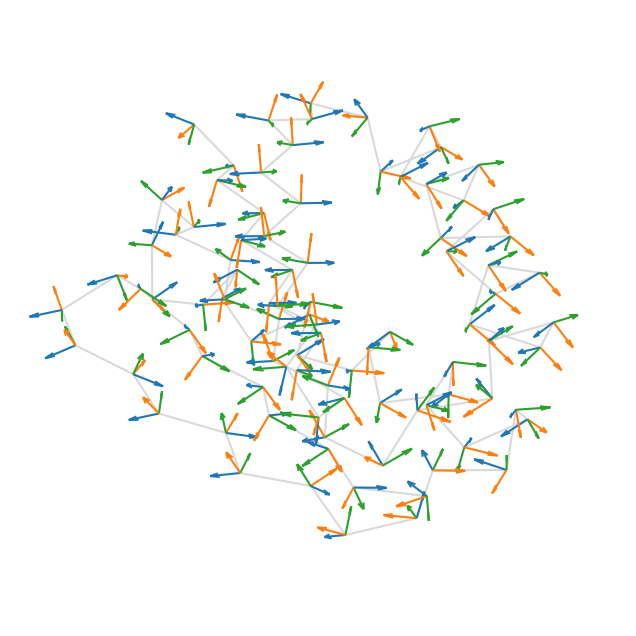

In [324]:
ax_lim = 5.5
fig, ax = plt.subplots(1, 1, figsize=[8, 8], subplot_kw=dict(projection="3d"))
ax.azim = 270  # xz view
rigids_0 = torch.clone(rigids_0)
se3_vec = au.rigids_to_se3_vec(du.move_to_np(rigids_0), scale_factor=1.0)
p = plot_se3(se3_vec, ax=ax, ax_lim=ax_lim)
plt.axis('off')
plt.grid(b=None)
plt.savefig('gt_frames.png', dpi=300)

/tmp/ipykernel_3850866/1769623568.py:21: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


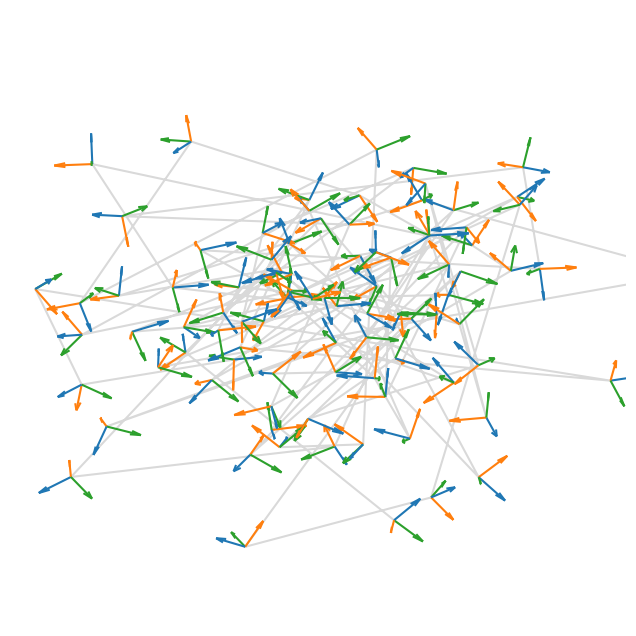

In [352]:
ax_lim = 5
fig, ax = plt.subplots(1, 1, figsize=[8, 8], subplot_kw=dict(projection="3d"))
ax.azim = 270  # xz view

se3_diff = exp.diffuser
aatype_probs = np.zeros([rigids_0.shape[0], 21])
rigids_0 = torch.clone(rigids_0)
rigids_1 = se3_diff.forward_marginal(
    rigids_0=ru.Rigid.from_tensor_7(rigids_0),
    aatype_probs_0=aatype_probs,
    t_seq=0.0,
    t_struct=1.0,
    diffuse_mask=None
)['rigids_t']
rigids_1[:, 4:] *= 0.3


se3_vec = au.rigids_to_se3_vec(du.move_to_np(rigids_1), scale_factor=1.0)
_ = plot_se3(se3_vec, ax=ax, ax_lim=ax_lim)
plt.axis('off')
plt.grid(b=None)
plt.savefig('initialized_frames.png', dpi=300)

torch.Size([92, 7])


/tmp/ipykernel_3850866/3391544647.py:24: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


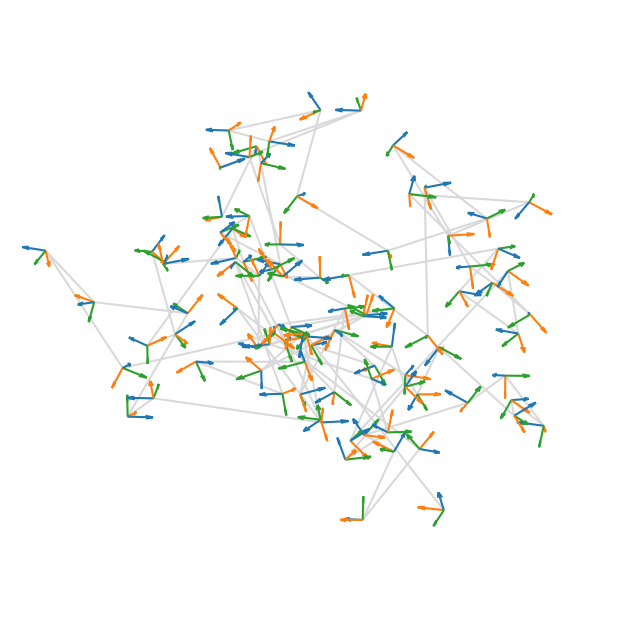

In [377]:
ax_lim = 7
fig, ax = plt.subplots(1, 1, figsize=[8, 8], subplot_kw=dict(projection="3d"))
ax.azim = 270  # xz view

se3_diff = exp.diffuser

chain_feats = train_loader[0].dataset._process_csv_row(top7_path)
gt_bb_rigid = ru.Rigid.from_tensor_4x4(chain_feats['rigidgroups_0'])[:, 0]
rigids_0 = gt_bb_rigid.to_tensor_7()

aatype_probs = np.zeros([rigids_0.shape[0], 21])
rigids_t = se3_diff.forward_marginal(
    rigids_0=ru.Rigid.from_tensor_7(rigids_0),
    aatype_probs_0=aatype_probs,
    t_seq=0.0,
    t_struct=0.1,
    diffuse_mask=None
)['rigids_t']
rigids_t[:, 4:] *= 0.55
print(rigids_t.shape)
se3_vec = au.rigids_to_se3_vec(du.move_to_np(rigids_t), scale_factor=1.0)
_ = plot_se3(se3_vec, ax=ax, ax_lim=ax_lim)
plt.axis('off')
plt.grid(b=None)
plt.savefig('noisy_rigids.png', dpi=300)